In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import mysql.connector
from mysql.connector import Error


import plotly.express as px
import plotly.graph_objects as go

## SQL - fetch data

In [28]:
def connect_to_database(database, host='localhost', user='root', password='password', v=True):
    try:
        connection = mysql.connector.connect(
            host=host,
            database=database,
            user=user,
            password=password
        )
        
        if connection.is_connected():
            db_info = connection.get_server_info()
            if v:
                print("Connected to MySQL Server version", db_info)
            cursor = connection.cursor()
            cursor.execute("select database();")
            record = cursor.fetchone()
            if v:
                print("You're connected to database:", record)
            return connection, cursor

    except Error as e:
        if v: 
            print("Error while connecting to MySQL", e)

    return None


In [29]:
def close_connection(connection, cursor):
    if cursor:
        cursor.close()
    if connection and connection.is_connected():
        connection.close()
        print("MySQL connection is closed")

In [30]:
con, cur = connect_to_database('flight_prediction')

Connected to MySQL Server version 8.3.0
You're connected to database: ('flight_prediction',)


In [31]:
def execute_query(connection, cursor, query, params=None):
    try:
        cursor.execute(query, params)
        if query.strip().lower().startswith('select') or query.strip().lower().startswith('show'):
            result = cursor.fetchall()
            return result
        else:
            connection.commit()
            return cursor.rowcount
    except Error as e:
        print("Error executing query:", e)
        return None

In [32]:
def put_res(results, query_type="SELECT"):
    if not results:
        print("No results found.")
        return

    if query_type.lower() in ["select", "show"]:
        for row in results:
            print(row)
    else:
        print(f"Affected rows: {results}")

In [33]:
res = execute_query(con, cur, 'SHOW TABLES', params=None)
put_res(res)

('airline',)
('airport',)
('delay',)
('flight',)
('states',)


In [34]:
# res = execute_query(con, cur, 'select * from flight join airport on origin_airport_seq_ID=airport_seq_ID join states on airport.state_ID=states.abr limit 10;', params=None)
# put_res(res)

In [35]:
def fetch_data_to_dataframe(connection, query):
    cursor = None
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        res = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        df = pd.DataFrame(res, columns=columns)
        return df
    except Error as e:
        print(f"Error fetching data: {e}")
        return None
    finally:
        if cursor:
            cursor.close()

In [36]:
# query = '''
# SELECT 
#     f.*, 
#     ao.airport_ID AS origin_airport_ID,
#     ao.airport_seq_ID AS origin_airport_seq_ID,
#     ao.city_market_ID AS origin_city_market_ID,
#     ao.city AS origin_city,
    
#     so.abr AS origin_state_abr,
#     so.FIPS AS origin_state_FIPS,
#     so.name AS origin_state_name,
#     so.WAC AS origin_state_WAC,
    
#     ad.airport_ID AS dest_airport_ID,
#     ad.airport_seq_ID AS dest_airport_seq_ID,
#     ad.city_market_ID AS dest_city_market_ID,
#     ad.city AS dest_city,
    
#     sd.abr AS dest_state_abr,
#     sd.FIPS AS dest_state_FIPS,
#     sd.name AS dest_state_name,
#     sd.WAC AS dest_state_WAC
# FROM 
#     flight f
# LEFT JOIN 
#     airport ao ON f.origin_airport_seq_ID = ao.airport_seq_ID
# LEFT JOIN 
#     states so ON ao.state_ID = so.abr
# LEFT JOIN 
#     airport ad ON f.dest_airport_seq_ID = ad.airport_seq_ID
# LEFT JOIN 
#     states sd ON ad.state_ID = sd.abr;limit 10
# '''
# df = fetch_data_to_dataframe(con, query)

In [37]:
query = '''
SELECT
    *
FROM 
    flight
'''
df_flight = fetch_data_to_dataframe(con, query)

In [38]:
df_flight

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time,arr_time,duration,distance,distance_group
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,986,4
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,986,4
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,986,4
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,986,4
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,986,4
...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5635963,2016-12-31,19393,N7703A,1077,1537602,1289204,755,830,95,451,2
5635963,5635964,2016-12-31,19393,N7815L,1345,1537602,1289204,1320,1355,95,451,2
5635964,5635965,2016-12-31,19393,N967WN,1176,1537602,1323202,705,1125,200,1440,6
5635965,5635966,2016-12-31,19393,N271LV,865,1537602,1467903,1220,1235,75,368,2


In [39]:
query = '''
SELECT 
    *
FROM 
    delay
'''
df_delay = fetch_data_to_dataframe(con, query)

In [40]:
query = '''
SELECT 
    *
FROM 
    states
'''
df_state = fetch_data_to_dataframe(con, query)

In [41]:
query = '''
SELECT 
    *
FROM 
    airport
'''
df_airport = fetch_data_to_dataframe(con, query)


In [42]:
query = '''
SELECT 
    *
FROM 
    airline
'''
df_airline = fetch_data_to_dataframe(con, query)

In [43]:
df_airport = pd.merge(df_airport, df_state, left_on='state_ID', right_on='abr', how='inner')
df_airport

,airport_ID,airport_seq_ID,city_market_ID,city,state_ID,abr,FIPS,name,WAC
0,10135,1013503,30135,"Allentown/Bethlehem/Easton, PA",PA,PA,42,Pennsylvania,23
1,10434,1043403,30434,"Scranton/Wilkes-Barre, PA",PA,PA,42,Pennsylvania,23
2,11577,1157704,31577,"Erie, PA",PA,PA,42,Pennsylvania,23
3,12898,1289803,32898,"Latrobe, PA",PA,PA,42,Pennsylvania,23
4,12898,1289804,32898,"Latrobe, PA",PA,PA,42,Pennsylvania,23
...,...,...,...,...,...,...,...,...,...
317,15370,1537002,34653,"Tulsa, OK",OK,OK,40,Oklahoma,73
318,13296,1329604,30721,"Manchester, NH",NH,NH,33,New Hampshire,14
319,14307,1430702,30721,"Providence, RI",RI,RI,44,Rhode Island,15
320,15024,1502403,34945,"Charlotte Amalie, VI",VI,VI,78,U.S. Virgin Islands,4


In [44]:
df_merged = pd.merge(df_flight, df_airline, on='airline_ID', how='inner')


In [45]:
df_merged = pd.merge(df_merged, df_airport, left_on='origin_airport_seq_ID', right_on='airport_seq_ID', how='inner')
df_merged

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time,arr_time,duration,...,carrier,airport_ID,airport_seq_ID,city_market_ID,city,state_ID,abr,FIPS,name,WAC
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,AA,11298,1129804,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,AA,11298,1129804,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,AA,11298,1129804,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,AA,11298,1129804,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,AA,11298,1129804,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5634288,2016-12-31,19393,N8327A,4247,1239102,1320402,820,1115,175,...,WN,12391,1239102,31703,"Islip, NY",NY,NY,36,New York,22
5635963,5634289,2016-12-31,19393,N559WN,6396,1239102,1320402,1555,1850,175,...,WN,12391,1239102,31703,"Islip, NY",NY,NY,36,New York,22
5635964,5634290,2016-12-31,19393,N201LV,1347,1239102,1402702,1535,1835,180,...,WN,12391,1239102,31703,"Islip, NY",NY,NY,36,New York,22
5635965,5634291,2016-12-31,19393,N217JC,6484,1239102,1402702,935,1230,175,...,WN,12391,1239102,31703,"Islip, NY",NY,NY,36,New York,22


In [46]:
df_merged = df_merged.drop(columns=['airport_seq_ID'])
df_merged.rename(columns={
    'airport_ID': 'origin_airport_ID',
    'city_market_ID': 'origin_city_market_ID',
    'city': 'origin_city',
    'state_ID': 'origin_state_ID',
    'abr': 'origin_abr',
    'FIPS': 'origin_FIPS',
    'name': 'origin_name',
    'WAC': 'origin_WAC'
    }, inplace=True)
df_merged

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time,arr_time,duration,...,distance_group,carrier,origin_airport_ID,origin_city_market_ID,origin_city,origin_state_ID,origin_abr,origin_FIPS,origin_name,origin_WAC
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,4,AA,11298,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,4,AA,11298,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,4,AA,11298,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,4,AA,11298,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,4,AA,11298,30194,"Dallas/Fort Worth, TX",TX,TX,48,Texas,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5634288,2016-12-31,19393,N8327A,4247,1239102,1320402,820,1115,175,...,4,WN,12391,31703,"Islip, NY",NY,NY,36,New York,22
5635963,5634289,2016-12-31,19393,N559WN,6396,1239102,1320402,1555,1850,175,...,4,WN,12391,31703,"Islip, NY",NY,NY,36,New York,22
5635964,5634290,2016-12-31,19393,N201LV,1347,1239102,1402702,1535,1835,180,...,5,WN,12391,31703,"Islip, NY",NY,NY,36,New York,22
5635965,5634291,2016-12-31,19393,N217JC,6484,1239102,1402702,935,1230,175,...,5,WN,12391,31703,"Islip, NY",NY,NY,36,New York,22


In [48]:
df_merged = pd.merge(df_merged, df_airport, left_on='dest_airport_seq_ID', right_on='airport_seq_ID', how='inner')
df_merged

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time,arr_time,duration,...,origin_WAC,airport_ID,airport_seq_ID,city_market_ID,city,state_ID,abr,FIPS,name,WAC
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,74,11433,1143302,31295,"Detroit, MI",MI,MI,26,Michigan,43
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,74,11433,1143302,31295,"Detroit, MI",MI,MI,26,Michigan,43
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,74,11433,1143302,31295,"Detroit, MI",MI,MI,26,Michigan,43
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,74,11433,1143302,31295,"Detroit, MI",MI,MI,26,Michigan,43
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,74,11433,1143302,31295,"Detroit, MI",MI,MI,26,Michigan,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5515254,2016-12-09,20304,N908SW,5102,1251902,1144703,1311,1359,48,...,66,11447,1144703,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66
5635963,5515257,2016-12-09,20304,N908SW,5104,1251902,1144703,2320,8,48,...,66,11447,1144703,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66
5635964,5517324,2016-12-19,20304,N937SW,5102,1251902,1144703,1313,1407,54,...,66,11447,1144703,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66
5635965,5517327,2016-12-19,20304,N915SW,5104,1251902,1144703,2320,14,54,...,66,11447,1144703,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66


In [49]:
df_merged = df_merged.drop(columns=['airport_seq_ID'])
df_merged.rename(columns={
    'airport_ID': 'dest_airport_ID',
    'city_market_ID': 'dest_city_market_ID',
    'city': 'dest_city',
    'state_ID': 'dest_state_ID',
    'abr': 'dest_abr',
    'FIPS': 'dest_FIPS',
    'name': 'dest_name',
    'WAC': 'dest_WAC'
    }, inplace=True)
df_merged

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time,arr_time,duration,...,origin_name,origin_WAC,dest_airport_ID,dest_city_market_ID,dest_city,dest_state_ID,dest_abr,dest_FIPS,dest_name,dest_WAC
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,Texas,74,11433,31295,"Detroit, MI",MI,MI,26,Michigan,43
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,Texas,74,11433,31295,"Detroit, MI",MI,MI,26,Michigan,43
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,Texas,74,11433,31295,"Detroit, MI",MI,MI,26,Michigan,43
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,Texas,74,11433,31295,"Detroit, MI",MI,MI,26,Michigan,43
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,Texas,74,11433,31295,"Detroit, MI",MI,MI,26,Michigan,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5515254,2016-12-09,20304,N908SW,5102,1251902,1144703,1311,1359,48,...,North Dakota,66,11447,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66
5635963,5515257,2016-12-09,20304,N908SW,5104,1251902,1144703,2320,8,48,...,North Dakota,66,11447,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66
5635964,5517324,2016-12-19,20304,N937SW,5102,1251902,1144703,1313,1407,54,...,North Dakota,66,11447,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66
5635965,5517327,2016-12-19,20304,N915SW,5104,1251902,1144703,2320,14,54,...,North Dakota,66,11447,31447,"Devils Lake, ND",ND,ND,38,North Dakota,66


In [50]:
df_merged = df_merged.drop(columns=['dest_abr'])
df_merged = df_merged.drop(columns=['origin_abr'])


In [51]:
df_merged

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time,arr_time,duration,...,origin_FIPS,origin_name,origin_WAC,dest_airport_ID,dest_city_market_ID,dest_city,dest_state_ID,dest_FIPS,dest_name,dest_WAC
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,48,Texas,74,11433,31295,"Detroit, MI",MI,26,Michigan,43
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,48,Texas,74,11433,31295,"Detroit, MI",MI,26,Michigan,43
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,48,Texas,74,11433,31295,"Detroit, MI",MI,26,Michigan,43
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,48,Texas,74,11433,31295,"Detroit, MI",MI,26,Michigan,43
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,48,Texas,74,11433,31295,"Detroit, MI",MI,26,Michigan,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5515254,2016-12-09,20304,N908SW,5102,1251902,1144703,1311,1359,48,...,38,North Dakota,66,11447,31447,"Devils Lake, ND",ND,38,North Dakota,66
5635963,5515257,2016-12-09,20304,N908SW,5104,1251902,1144703,2320,8,48,...,38,North Dakota,66,11447,31447,"Devils Lake, ND",ND,38,North Dakota,66
5635964,5517324,2016-12-19,20304,N937SW,5102,1251902,1144703,1313,1407,54,...,38,North Dakota,66,11447,31447,"Devils Lake, ND",ND,38,North Dakota,66
5635965,5517327,2016-12-19,20304,N915SW,5104,1251902,1144703,2320,14,54,...,38,North Dakota,66,11447,31447,"Devils Lake, ND",ND,38,North Dakota,66


In [53]:
df = pd.merge(df_merged, df_delay, on='ID', how='inner')
df

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time_x,arr_time_x,duration,...,arr_delay_group,cancelled,diverted,actual_elapsed_time,air_time,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,-1.0,0,0,155.0,132.0,NaN,NaN,NaN,NaN,NaN
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,-1.0,0,0,150.0,126.0,NaN,NaN,NaN,NaN,NaN
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,0.0,0,0,170.0,135.0,NaN,NaN,NaN,NaN,NaN
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,-1.0,0,0,151.0,129.0,NaN,NaN,NaN,NaN,NaN
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,7.0,0,0,171.0,137.0,0.0,0.0,47.0,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5515254,2016-12-09,20304,N908SW,5102,1251902,1144703,1311,1359,48,...,-1.0,0,0,48.0,23.0,NaN,NaN,NaN,NaN,NaN
5635963,5515257,2016-12-09,20304,N908SW,5104,1251902,1144703,2320,8,48,...,-2.0,0,0,36.0,19.0,NaN,NaN,NaN,NaN,NaN
5635964,5517324,2016-12-19,20304,N937SW,5102,1251902,1144703,1313,1407,54,...,-2.0,0,0,36.0,20.0,NaN,NaN,NaN,NaN,NaN
5635965,5517327,2016-12-19,20304,N915SW,5104,1251902,1144703,2320,14,54,...,-2.0,0,0,35.0,22.0,NaN,NaN,NaN,NaN,NaN


In [54]:
df.columns.to_list()

['ID',
 'date',
 'airline_ID',
 'tail_num',
 'fl_num',
 'origin_airport_seq_ID',
 'dest_airport_seq_ID',
 'dep_time_x',
 'arr_time_x',
 'duration',
 'distance',
 'distance_group',
 'carrier',
 'origin_airport_ID',
 'origin_city_market_ID',
 'origin_city',
 'origin_state_ID',
 'origin_FIPS',
 'origin_name',
 'origin_WAC',
 'dest_airport_ID',
 'dest_city_market_ID',
 'dest_city',
 'dest_state_ID',
 'dest_FIPS',
 'dest_name',
 'dest_WAC',
 'dep_time_y',
 'dep_delay',
 'dep_delay_group',
 'taxi_out',
 'wheels_off',
 'wheels_on',
 'taxi_in',
 'arr_time_y',
 'arr_delay',
 'arr_delay_group',
 'cancelled',
 'diverted',
 'actual_elapsed_time',
 'air_time',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

In [ ]:
# close_connection(con, cur)

## Temporality

 10,000,000 scheduled passenger flights handled by FAA yearly

In [59]:
start_date = df['date'].min()
end_date = df['date'].max()

print(f"Starting date of the data: {start_date}")
print(f"Ending date of the data: {end_date}")

Starting date of the data: 2016-01-01 00:00:00
Ending date of the data: 2016-12-31 00:00:00


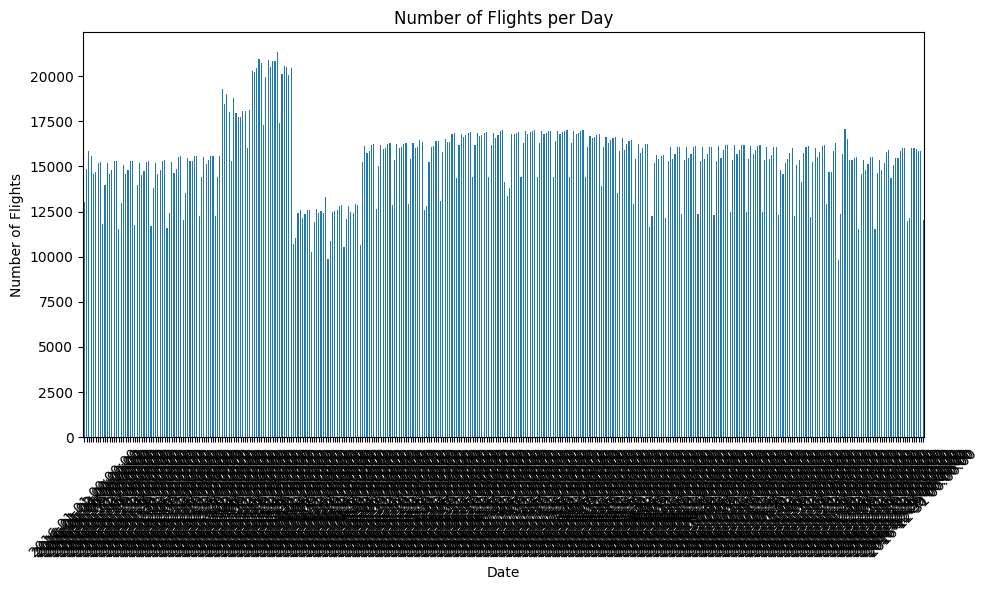

In [57]:
flights_per_day = df_flight.groupby('date').size()

# Plot the number of flights per day
plt.figure(figsize=(10, 6))
flights_per_day.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

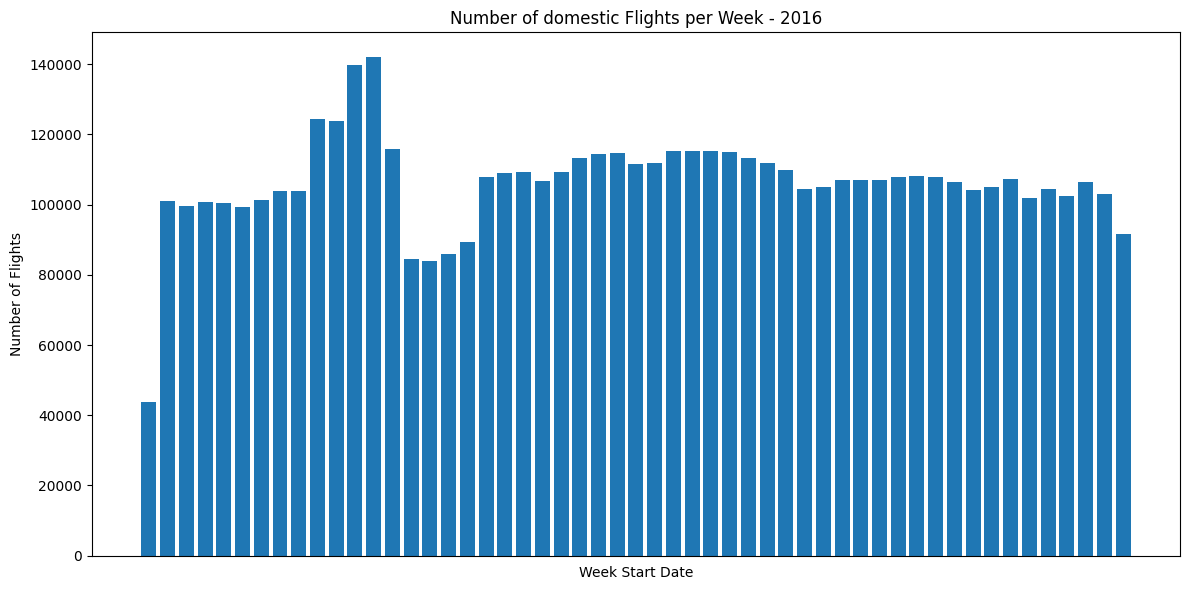

In [61]:
# Create a new column for the start of the week
df['week_start'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by the start of the week and count the number of flights per week
flights_per_week = df.groupby('week_start').size().reset_index(name='flights')

# Plot the number of flights per week
plt.figure(figsize=(12, 6))
plt.bar(flights_per_week['week_start'].astype(str), flights_per_week['flights'])
plt.xlabel('Week Start Date')
plt.ylabel('Number of Flights')
plt.title('Number of domestic Flights per Week - 2016')
plt.xticks([], [])  # This line removes the x-axis labels

plt.tight_layout()
plt.show()

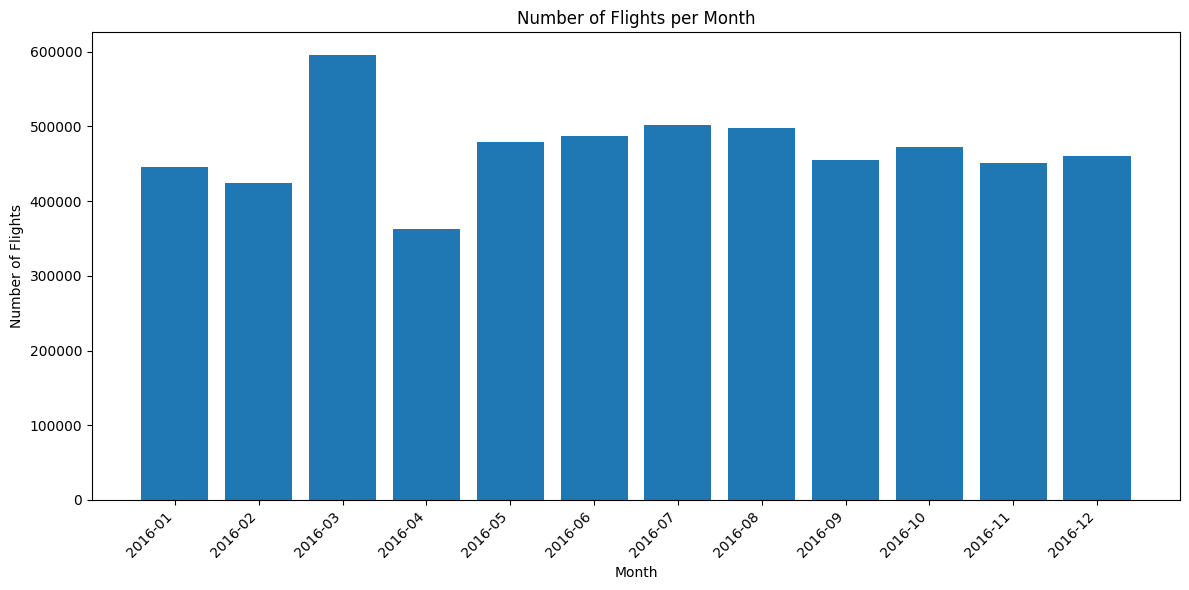

In [62]:

# Create a new column for the month and year
df['month_year'] = df['date'].dt.to_period('M').astype(str)

# Group by the month and count the number of flights per month
flights_per_month = df.groupby('month_year').size().reset_index(name='flights')

# Plot the number of flights per month
plt.figure(figsize=(12, 6))
plt.bar(flights_per_month['month_year'], flights_per_month['flights'])
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.title('Number of domestic Flights per Month - 2016')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

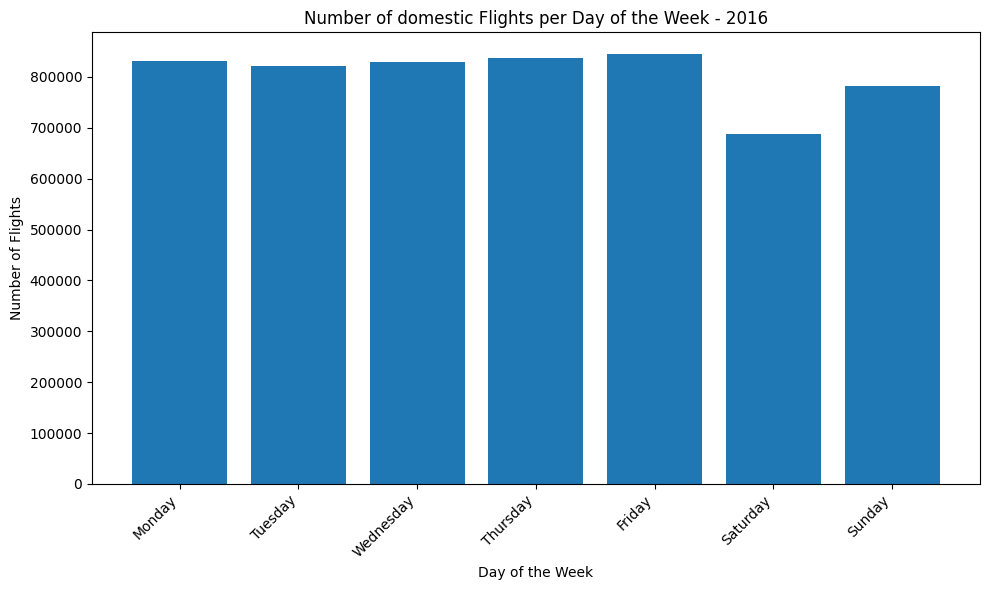

In [63]:
# Create a new column for the day of the week
df['day_of_week'] = df['date'].dt.day_name()

# Group by the day of the week and count the number of flights per day
flights_per_day = df.groupby('day_of_week').size().reset_index(name='flights')

# To ensure the days are ordered correctly
days_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
flights_per_day['day_of_week'] = pd.Categorical(flights_per_day['day_of_week'], categories=days_of_week_order, ordered=True)
flights_per_day = flights_per_day.sort_values('day_of_week')

# Plot the number of flights per day of the week
plt.figure(figsize=(10, 6))
plt.bar(flights_per_day['day_of_week'], flights_per_day['flights'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.title('Number of domestic Flights per Day of the Week - 2016')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [65]:
df['arr_delay_bool'] = df['arr_delay'].apply(lambda x: 1 if x > 0 else 0)

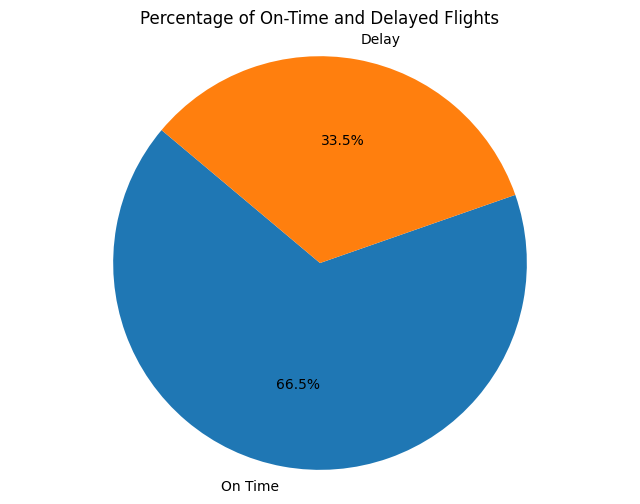

In [66]:
delay_counts = df['arr_delay_bool'].value_counts()

# Plot the pie chart
labels = ['On Time', 'Delay']
colors = ['#1f77b4', '#ff7f0e']  # Customize colors if desired

plt.figure(figsize=(8, 6))
plt.pie(delay_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of On-Time and Delayed Flights')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [67]:
df['arr_delay_pos'] = np.where(df['arr_delay'] > 0, df['arr_delay'], 0)

ID                       int64
dep_time               float64
dep_delay              float64
dep_delay_group        float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
arr_time               float64
arr_delay              float64
arr_delay_group        float64
cancelled                int64
diverted                 int64
actual_elapsed_time    float64
air_time               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object

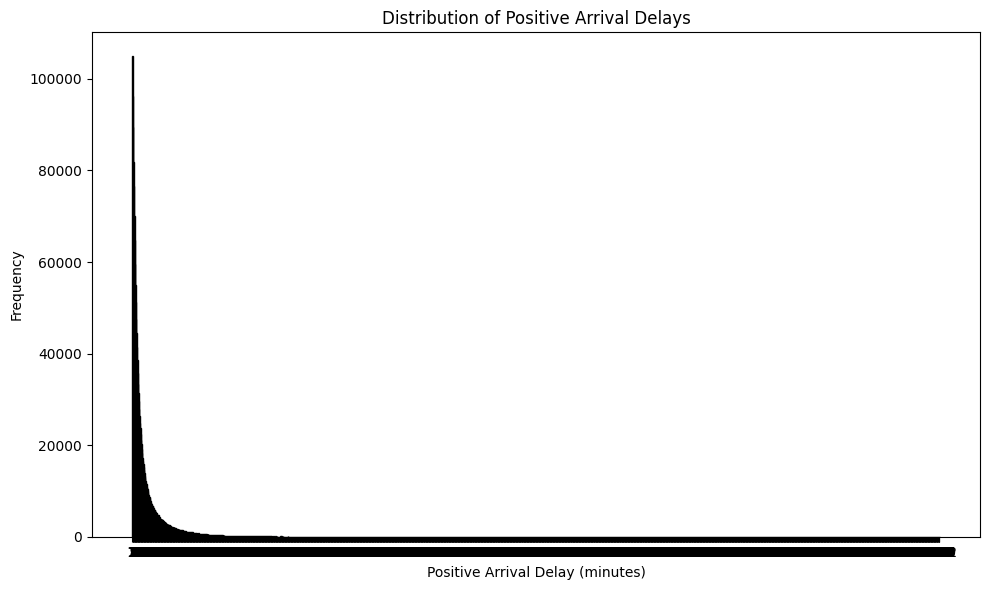

In [75]:

# Create arr_delay_pos column
df['arr_delay_pos'] = np.where(df['arr_delay'] > 0, df['arr_delay'], 0)

# Filter positive values
positive_delays = df[df['arr_delay_pos'] > 0]['arr_delay_pos']

# Plot the distribution of positive values
plt.figure(figsize=(10, 6))
plt.hist(positive_delays, bins=range(1, int(positive_delays.max()) + 2), edgecolor='black')
plt.xlabel('Positive Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Positive Arrival Delays')
plt.xticks(range(1, int(positive_delays.max()) + 1))
plt.tight_layout()
plt.show()

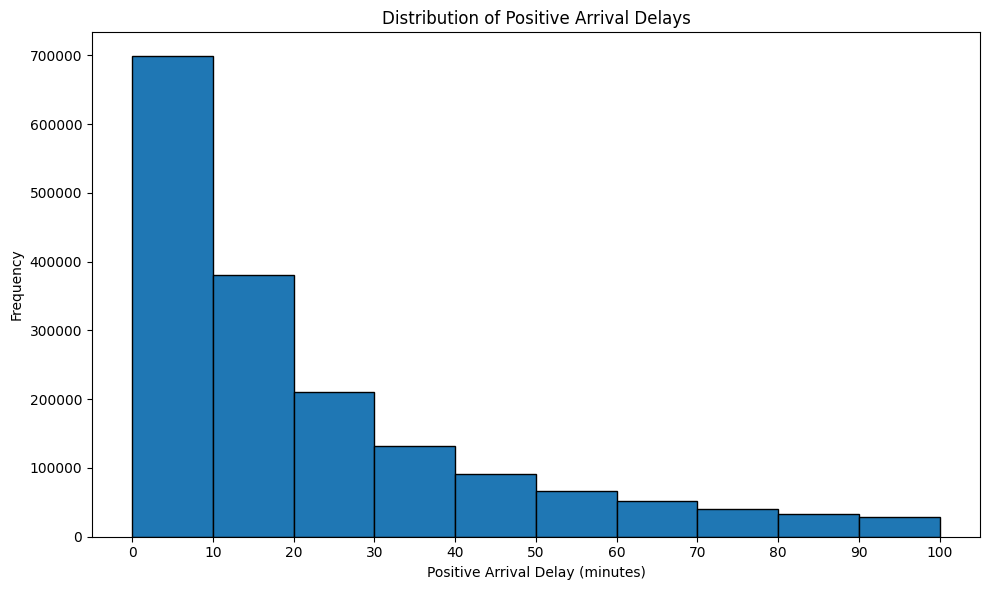

In [76]:
# Filter positive values and limit to a maximum of 100
positive_delays = df[df['arr_delay_pos'] > 0]['arr_delay_pos']
positive_delays = positive_delays[positive_delays <= 100]

# Plot the distribution of positive values with bins of size 10
plt.figure(figsize=(10, 6))
plt.hist(positive_delays, bins=range(0, 110, 10), edgecolor='black')
plt.xlabel('Positive Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Positive Arrival Delays')
plt.xticks(range(0, 110, 10))
plt.tight_layout()
plt.show()

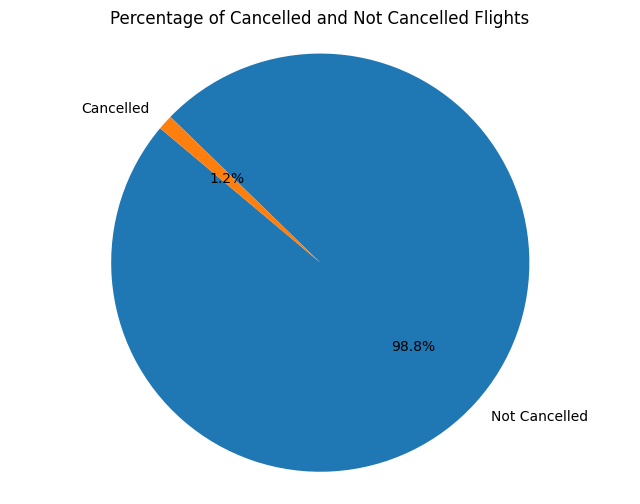

In [77]:
# Count the occurrences of each value in the 'cancelled' column
cancelled_counts = df['cancelled'].value_counts()

# Plot the pie chart
labels = ['Not Cancelled', 'Cancelled']
colors = ['#1f77b4', '#ff7f0e']  # Customize colors if desired

plt.figure(figsize=(8, 6))
plt.pie(cancelled_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Cancelled and Not Cancelled Flights')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

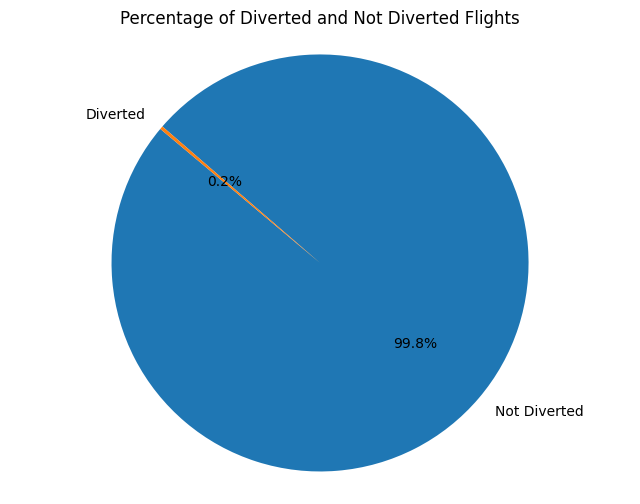

In [78]:

# Count the occurrences of each value in the 'diverted' column
diverted_counts = df['diverted'].value_counts()

# Plot the pie chart
labels = ['Not Diverted', 'Diverted']
colors = ['#1f77b4', '#ff7f0e']  # Customize colors if desired

plt.figure(figsize=(8, 6))
plt.pie(diverted_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Diverted and Not Diverted Flights')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

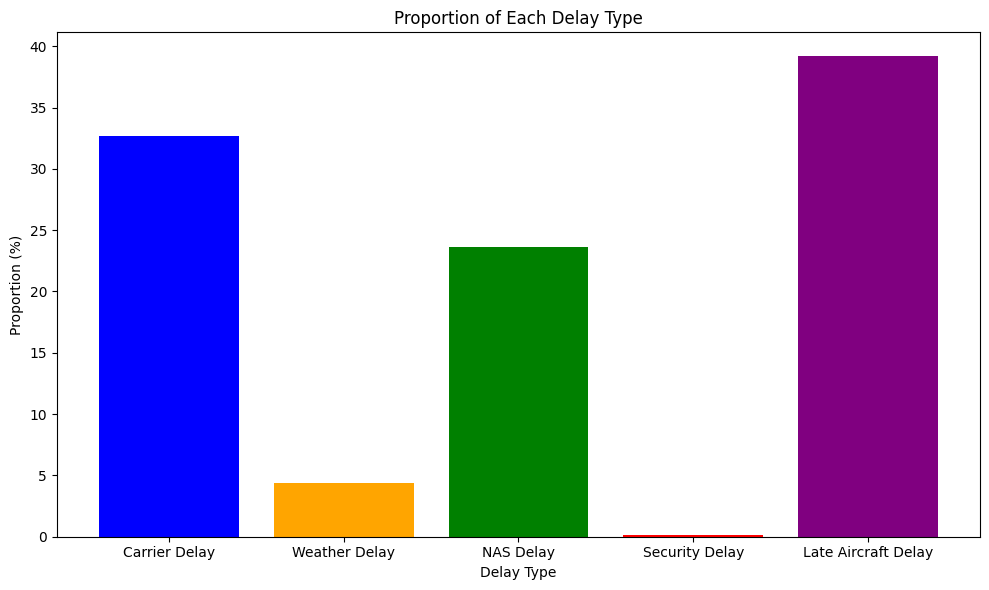

In [80]:
delay_counts = {
    'Carrier Delay': df['carrier_delay'].sum(),
    'Weather Delay': df['weather_delay'].sum(),
    'NAS Delay': df['nas_delay'].sum(),
    'Security Delay': df['security_delay'].sum(),
    'Late Aircraft Delay': df['late_aircraft_delay'].sum()
}

# Calculate total delays
total_delays = sum(delay_counts.values())

# Calculate the proportion percentage for each delay type
delay_proportions = {k: (v / total_delays) * 100 for k, v in delay_counts.items()}

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(delay_proportions.keys(), delay_proportions.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Delay Type')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Each Delay Type')
plt.tight_layout()
plt.show()

Carrier Delay
Definition: Delays caused by the airline itself.

Examples:

Aircraft maintenance or crew issues.
Baggage loading problems.
Late arrival of the aircraft from a previous flight.
Weather Delay
Definition: Delays caused by weather conditions.

Examples:

Severe weather conditions such as thunderstorms, snowstorms, fog, or hurricanes.
Low visibility or other weather-related factors that affect flight safety.
NAS Delay (National Airspace System Delay)
Definition: Delays caused by the national airspace system.

Examples:

Air traffic control delays.
Airport operations issues (e.g., long queues for takeoff).
Heavy air traffic volume.
Security Delay
Definition: Delays caused by security-related issues.

Examples:

Security breaches or threats.
Increased security checks and procedures.
Evacuations or other security protocols.
Late Aircraft Delay
Definition: Delays caused by the late arrival of the aircraft from a previous flight.

Examples:

The aircraft arriving late from a previous route, thus delaying the next scheduled departure.
Knock-on effects from earlier delays.

In [82]:
df['origin_state_ID']

0          TX
1          TX
2          TX
3          TX
4          TX
           ..
5635962    ND
5635963    ND
5635964    ND
5635965    ND
5635966    TT
Name: origin_state_ID, Length: 5635967, dtype: object

In [83]:
import plotly.express as px

state_counts = df['origin_state_ID'].value_counts().reset_index()
state_counts.columns = ['state', 'flights']

fig = px.choropleth(
    state_counts,
    locations='state',
    locationmode='USA-states',
    color='flights',
    color_continuous_scale='OrRd',
    scope='usa',
    title='Flight Distribution by Origin State'
)

fig.show()

In [84]:


state_counts = df['dest_state_ID'].value_counts().reset_index()
state_counts.columns = ['state', 'flights']

fig = px.choropleth(
    state_counts,
    locations='state',
    locationmode='USA-states',
    color='flights',
    color_continuous_scale='OrRd',
    scope='usa',
    title='Flight Distribution by Destination State'
)

fig.show()

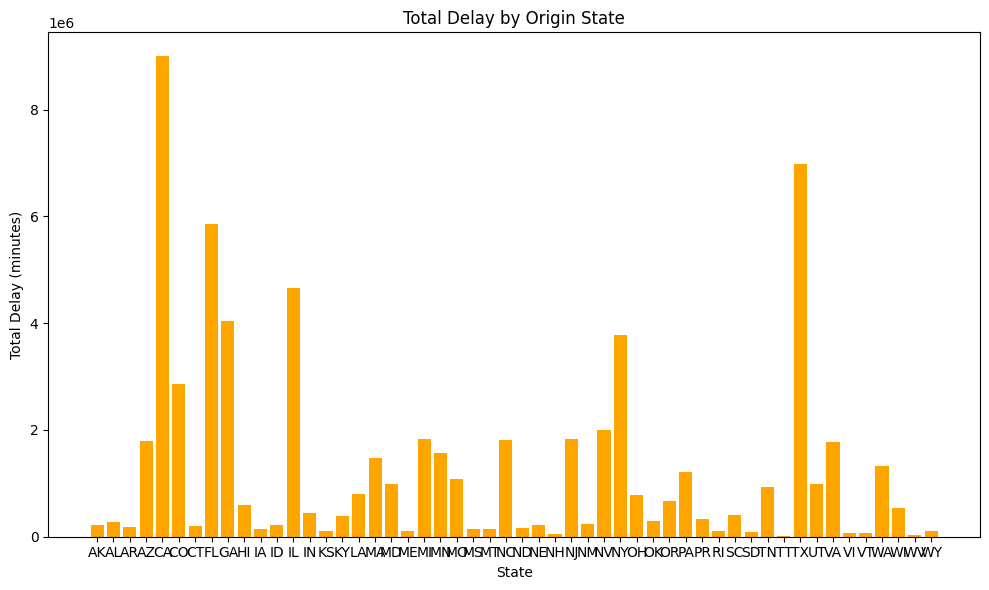

In [85]:
state_delay = df.groupby('origin_state_ID')['arr_delay_pos'].sum().reset_index()
state_delay.columns = ['state', 'total_delay']

# Find the state with the maximum total delay
most_late_state = state_delay.loc[state_delay['total_delay'].idxmax()]

# Plot the total delay for each state
plt.figure(figsize=(10, 6))
plt.bar(state_delay['state'], state_delay['total_delay'], color='orange')
plt.xlabel('State')
plt.ylabel('Total Delay (minutes)')
plt.title('Total Delay by Origin State')
plt.tight_layout()
plt.show()

In [92]:
state_flight_counts = df.groupby('origin_state_ID').size().reset_index(name='total_flights')
state_delay_counts = df.groupby('origin_state_ID')['arr_delay_pos'].sum().reset_index(name='total_delays')

state_stats = pd.merge(state_flight_counts, state_delay_counts, on='origin_state_ID')

state_stats['delay_percentage'] = (state_stats['total_delays'] / state_stats['total_flights']) * 100
state_stats.columns = ['state', 'total_flights', 'total_delays', 'delay_percentage']

fig = px.choropleth(
    state_stats,
    locations='state',
    locationmode='USA-states',
    color='delay_percentage',
    color_continuous_scale='OrRd',
    scope='usa',
    title='Proportion of Delayed Flights by Origin State'
)

fig.show()

In [97]:
state_coords = {
    'AL': (-86.902298, 32.318231),
    'AK': (-149.493673, 64.200841),
    'AZ': (-111.093731, 34.048928),
    'AR': (-92.131378, 35.20105),
    'CA': (-119.417932, 36.778261),
    'CO': (-105.782067, 39.550051),
    'CT': (-72.755371, 41.603221),
    'DE': (-75.52767, 38.910832),
    'FL': (-81.515754, 27.664827),
    'GA': (-82.907123, 32.157435),
    'HI': (-155.582782, 19.896766),
    'ID': (-114.742041, 44.068202),
    'IL': (-89.398528, 40.633125),
    'IN': (-86.134902, 40.267194),
    'IA': (-93.097702, 41.878003),
    'KS': (-98.484246, 39.011902),
    'KY': (-84.270018, 37.839333),
    'LA': (-91.962333, 30.984298),
    'ME': (-69.445469, 45.253783),
    'MD': (-76.641271, 39.045755),
    'MA': (-71.382437, 42.407211),
    'MI': (-85.602364, 44.314844),
    'MN': (-94.6859, 46.729553),
    'MS': (-89.398528, 32.354668),
    'MO': (-91.831833, 37.964253),
    'MT': (-110.362566, 46.879682),
    'NE': (-99.901813, 41.492537),
    'NV': (-116.419389, 38.80261),
    'NH': (-71.572395, 43.193852),
    'NJ': (-74.405661, 40.058324),
    'NM': (-105.87009, 34.51994),
    'NY': (-74.217933, 43.299428),
    'NC': (-79.0193, 35.759573),
    'ND': (-101.002012, 47.551493),
    'OH': (-82.907123, 40.417287),
    'OK': (-97.516428, 35.007752),
    'OR': (-120.554201, 43.804133),
    'PA': (-77.194525, 41.203322),
    'RI': (-71.477429, 41.580095),
    'SC': (-81.163725, 33.836081),
    'SD': (-99.901813, 43.969515),
    'TN': (-86.580447, 35.517491),
    'TX': (-99.901813, 31.968599),
    'UT': (-111.093731, 39.32098),
    'VT': (-72.577841, 44.558803),
    'VA': (-78.656894, 37.431573),
    'WA': (-120.740139, 47.751074),
    'WV': (-80.454903, 38.597626),
    'WI': (-89.616508, 43.78444),
    'WY': (-107.290284, 43.075968)
}

In [98]:
df

,ID,date,airline_ID,tail_num,fl_num,origin_airport_seq_ID,dest_airport_seq_ID,dep_time_x,arr_time_x,duration,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,week,week_start,month_year,day_of_week,arr_delay_bool,arr_delay_pos
0,1,2016-01-06,19805,N4YBAA,43,1129804,1143302,1100,1438,158,...,NaN,NaN,NaN,NaN,2016-01-04,2016-01-04,2016-01,Wednesday,0,0.0
1,2,2016-01-07,19805,N434AA,43,1129804,1143302,1100,1438,158,...,NaN,NaN,NaN,NaN,2016-01-04,2016-01-04,2016-01,Thursday,0,0.0
2,3,2016-01-08,19805,N541AA,43,1129804,1143302,1100,1438,158,...,NaN,NaN,NaN,NaN,2016-01-04,2016-01-04,2016-01,Friday,1,7.0
3,4,2016-01-09,19805,N489AA,43,1129804,1143302,1100,1438,158,...,NaN,NaN,NaN,NaN,2016-01-04,2016-01-04,2016-01,Saturday,0,0.0
4,5,2016-01-10,19805,N439AA,43,1129804,1143302,1100,1438,158,...,0.0,47.0,0.0,66.0,2016-01-04,2016-01-04,2016-01,Sunday,1,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635962,5515254,2016-12-09,20304,N908SW,5102,1251902,1144703,1311,1359,48,...,NaN,NaN,NaN,NaN,2016-12-05,2016-12-05,2016-12,Friday,0,0.0
5635963,5515257,2016-12-09,20304,N908SW,5104,1251902,1144703,2320,8,48,...,NaN,NaN,NaN,NaN,2016-12-05,2016-12-05,2016-12,Friday,0,0.0
5635964,5517324,2016-12-19,20304,N937SW,5102,1251902,1144703,1313,1407,54,...,NaN,NaN,NaN,NaN,2016-12-19,2016-12-19,2016-12,Monday,0,0.0
5635965,5517327,2016-12-19,20304,N915SW,5104,1251902,1144703,2320,14,54,...,NaN,NaN,NaN,NaN,2016-12-19,2016-12-19,2016-12,Monday,0,0.0
